<b>Google Colab</b> <a href="https://colab.research.google.com/github/kirillzyusko/stock-predictions/blob/master/lab.ipynb">link</a>

Helper functions:


In [1]:
import pandas as pd

def one_hot(dataframe, column):
    # use pd.concat to join the new columns with your original dataframe
    df = pd.concat([dataframe, pd.get_dummies(dataframe[column], prefix=column)], axis=1)
    # now drop the original column (you don't need it anymore)
    df.drop([column], axis=1, inplace=True)

    return df

def inner_join(df1, df2, column):
    return pd.concat([df1.set_index(column),df2.set_index(column)], axis=1, join='inner').reset_index()

def where_equal(df, column, value):
    return df[df[column] == value]

def week_from_date(df, column):
    df[column] = pd.to_datetime(df[column], errors='coerce')
    df['week'] = df[column].dt.week
    df = df = one_hot(df, 'week')
    return df

def lags(df, range, key):
    ds = df[key]
    df.drop([key], axis=1, inplace=True)
    stocks = 1115
    concatable = [df, ds.fillna(0)]
    for i in range:
        concatable.append(ds.shift(stocks * i).fillna(0).rename(f'{key}_{i}'))
    return pd.concat(concatable, axis=1)

Now we write our **classificator** for reducing incoming data dimensionality and grouping similar providers. We will use [AgglomerativeClustering](https://https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering) for this purpose:

In [2]:
train = pd.read_csv('https://raw.githubusercontent.com/kirillzyusko/stock-predictions/master/train.csv')
store_states = pd.read_csv('https://raw.githubusercontent.com/kirillzyusko/stock-predictions/master/store_states.csv')
store = pd.read_csv('https://raw.githubusercontent.com/kirillzyusko/stock-predictions/master/store.csv')

def get_store_data():
    df = inner_join(store_states, store, 'Store')
    df = one_hot(df, 'State')
    df = one_hot(df, 'StoreType')
    df = one_hot(df, 'Assortment')
    agg = train.groupby('Store')['Sales'].agg([pd.np.mean]).reset_index()
    df = pd.concat([df, agg], axis=1)

    df.drop([
            'PromoInterval',
            'Promo2',
            'Promo2SinceWeek',
            'Promo2SinceYear',
            'CompetitionDistance',
            'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear'
        ], axis=1, inplace=True)
    
    return df.loc[:,~df.columns.duplicated()]

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer

import pandas as pd
import numpy as np

train_data = get_store_data()
train_data.drop(['Store'], axis=1, inplace=True)

from sklearn.preprocessing import StandardScaler

standardized_data = StandardScaler().fit_transform(train_data)

print(standardized_data)

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,200))

#visualizer.fit(standardized_data)  # Fit the data to the visualizer
#visualizer.show()  # Finalize and render the figure

K = 300 # num of clusters
model = AgglomerativeClustering(n_clusters=K, affinity='euclidean', linkage='ward')# KMeans(n_clusters=K)
predicted = model.fit_predict(standardized_data)

print(predicted)
store.insert(loc=0, column='K', value=predicted)

First pipeline - data processing, including: one-hot encoding, adding time lags and so on

In [22]:
def get_data():
    df = one_hot(train, 'DayOfWeek')
    df = week_from_date(df, 'Date')
    store = get_store_data()

    df = inner_join(df, store, 'Store')
    #df = one_hot(df, 'StoreType')
    #df = one_hot(df, 'Assortment')
    df = one_hot(df, 'K')
    #df = one_hot(df, 'Store')
    df = lags(df, [1,2,3,4,5,6,7,8,9,10,11,12,13,14], 'Sales')

    df.drop([
        'StateHoliday',
        'SchoolHoliday',
        'Date',
        #'K',
        'Store',
        'Customers',
        'Open',
        'Promo',
        'mean',
        'State_BE',
        'State_BW',
        'State_BY',
        'State_HB,NI',
        'State_HE',
        'State_HH',
        'State_NW',
        'State_RP',
        'State_SH',
        'State_SN',
        'State_ST',
        'State_TH'
    ], axis=1, inplace=True)

    # df = where_equal(df, 'Store_1', 1)
    # print(list(df))

    return df

def to_3d(n=1115):
    df = get_data()
    olap = []
    for i in range(n):
        olap.append(where_equal(df, 'Store', i))

    return olap

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = get_data()

y = data['Sales']
data.drop(['Sales'], axis=1, inplace=True)
X = data

scaler = StandardScaler()
standardized_data = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(standardized_data, y, test_size=0.10, random_state=42)

length, features = X_train.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  # Remove the CWD from sys.path while we load stuff.


In [33]:
from sklearn.externals import joblib

joblib.dump(scaler, '/content/gdrive/My Drive/scaler.pkl') 

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['/content/gdrive/My Drive/scaler.pkl']

In [ ]:
print(repr(X_train[0]))

In [24]:
list(data)

['DayOfWeek_1',
 'DayOfWeek_2',
 'DayOfWeek_3',
 'DayOfWeek_4',
 'DayOfWeek_5',
 'DayOfWeek_6',
 'DayOfWeek_7',
 'week_1',
 'week_2',
 'week_3',
 'week_4',
 'week_5',
 'week_6',
 'week_7',
 'week_8',
 'week_9',
 'week_10',
 'week_11',
 'week_12',
 'week_13',
 'week_14',
 'week_15',
 'week_16',
 'week_17',
 'week_18',
 'week_19',
 'week_20',
 'week_21',
 'week_22',
 'week_23',
 'week_24',
 'week_25',
 'week_26',
 'week_27',
 'week_28',
 'week_29',
 'week_30',
 'week_31',
 'week_32',
 'week_33',
 'week_34',
 'week_35',
 'week_36',
 'week_37',
 'week_38',
 'week_39',
 'week_40',
 'week_41',
 'week_42',
 'week_43',
 'week_44',
 'week_45',
 'week_46',
 'week_47',
 'week_48',
 'week_49',
 'week_50',
 'week_51',
 'week_52',
 'StoreType_a',
 'StoreType_b',
 'StoreType_c',
 'StoreType_d',
 'Assortment_a',
 'Assortment_b',
 'Assortment_c',
 'K_0',
 'K_1',
 'K_2',
 'K_3',
 'K_4',
 'K_5',
 'K_6',
 'K_7',
 'K_8',
 'K_9',
 'K_10',
 'K_11',
 'K_12',
 'K_13',
 'K_14',
 'K_15',
 'K_16',
 'K_17',
 'K_18

In [25]:
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras import regularizers
from keras.layers import Dropout

model = Sequential()

model.add(Dense(int(1774), input_dim=features, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.001), activation='relu', name='hidden_1'))
model.add(BatchNormalization())
#model.add(Dropout(0.4, name='dropout_1'))

model.add(Dense(int(1183), kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l2(0.001), name='hidden_2'))
model.add(BatchNormalization())
model.add(Dense(int(1183), kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l2(0.001), name='hidden_21'))
model.add(BatchNormalization())
#model.add(Dropout(0.4, name='dropout_2'))

model.add(Dense(int(591), kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l2(0.001), name='hidden_3'))
model.add(BatchNormalization())
model.add(Dense(int(591), kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l2(0.001), name='hidden_31'))
model.add(BatchNormalization())
#model.add(Dropout(0.5, name='dropout_3'))

model.add(Dense(1, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.001), name='output_layer'))

# Compile model
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 1774)              675894    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1774)              7096      
_________________________________________________________________
hidden_2 (Dense)             (None, 1183)              2099825   
_________________________________________________________________
batch_normalization_2 (Batch (None, 1183)              4732      
_________________________________________________________________
hidden_21 (Dense)            (None, 1183)              1400672   
_________________________________________________________________
batch_normalization_3 (Batch (None, 1183)              4732      
_________________________________________________________________
hidden_3 (Dense)             (None, 591)              

In [26]:
model.fit(X_train, y_train,
          epochs=1,
          validation_data=(X_test, y_test),
          verbose=1)

score = model.evaluate(X_test, y_test, verbose=0)
print(score)

Train on 915488 samples, validate on 101721 samples
Epoch 1/1
915488/915488 [==============================] - 321s 350us/step - loss: 4068572.3107 - accuracy: 3.8449e-04 - val_loss: 1199725.6526 - val_accuracy: 5.8985e-04
[1199725.652647929, 0.0005898487288504839]


In [27]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [30]:
model_save_name = 'model-warehouse-stock-prediction.h5'
path = F"/content/gdrive/My Drive/{model_save_name}" 
model.save_weights(path)

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

p = model.predict(X_test)

print(p[0], y_test[0])

mean_squared_error(y_test, p)

[148.84662] 5263


1054651.3453743998

Decision trees

Random forest

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 5, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=5, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
p = rf.predict(X_test)

mean_squared_error(y_test, p)

1220848.4723657847

Gradient boosting

In [ ]:
import xgboost as xgboost

xgb = xgboost.XGBRegressor(n_estimators=10, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=50)

xgb.fit(X_train,y_train)

[15:56:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.08, max_delta_step=0,
             max_depth=50, min_child_weight=1, missing=None, n_estimators=10,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.75, verbosity=1)

In [ ]:
p = xgb.predict(X_test)

mean_squared_error(y_test, p)

10217459.825583091

Linear regression

In [ ]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()  
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
from sklearn.metrics import mean_squared_error

p = regressor.predict(X_test)

mean_squared_error(y_test, p)

4038101.2924463437

Check predictions using charts:

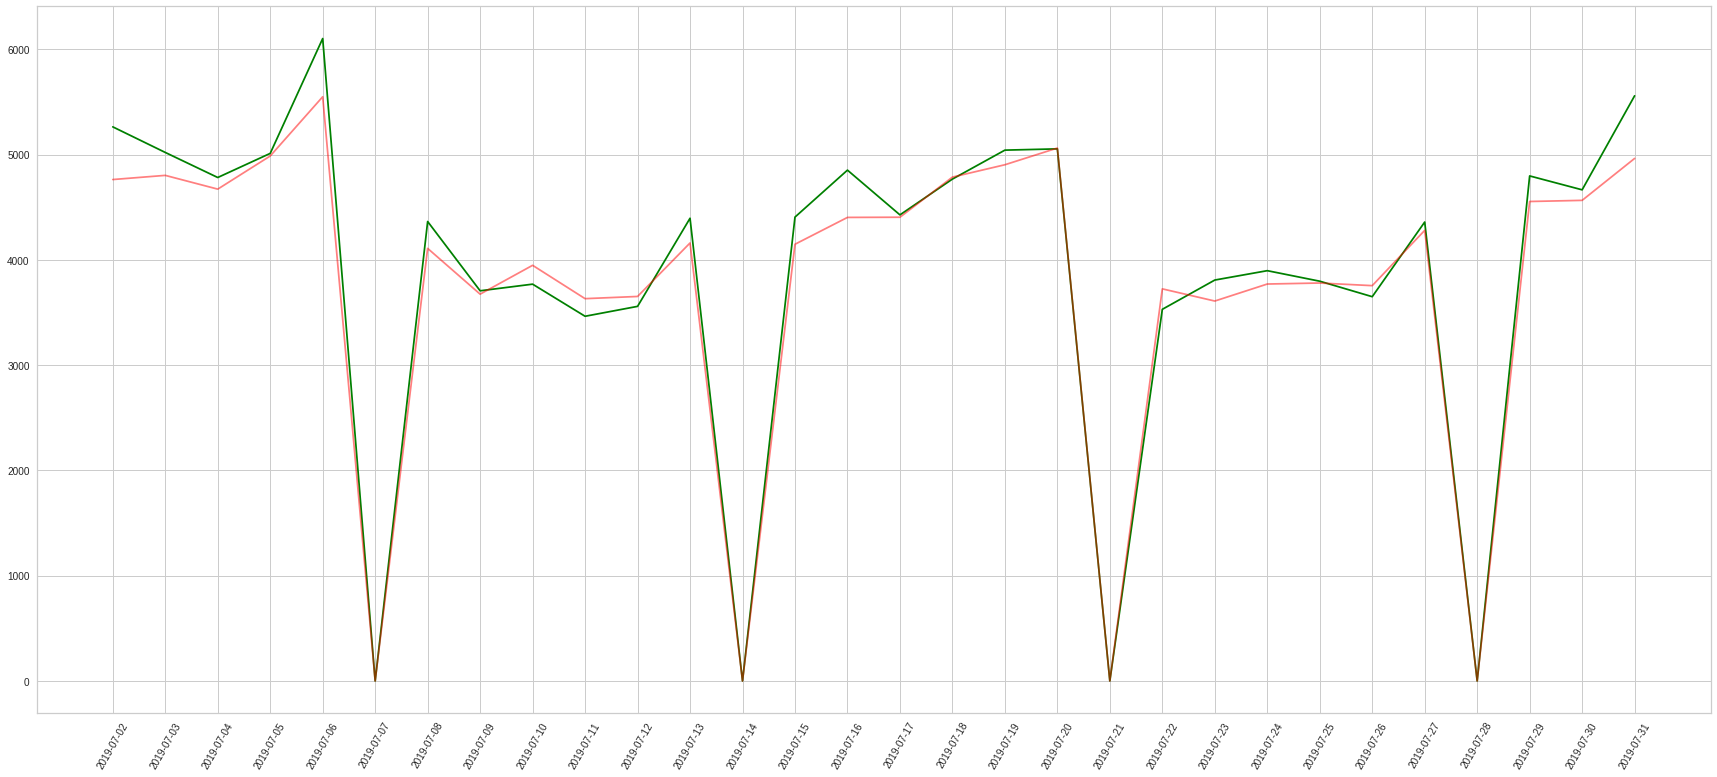

In [ ]:
import matplotlib.pyplot as plt
import datetime
plt.rcParams['figure.figsize'] = [30, 13]

data = get_data()

def draw_chart(id=1):
    y_vis = data[data[f'Store_{id}'] == id]['Sales'][0:30]
    X_vis = data[data[f'Store_{id}'] == id][0:30]

    X_vis.drop(['Sales'], axis=1, inplace=True)

    X_vis = scaler.transform(X_vis)

    dates = []
    base = datetime.datetime.strptime('2019-07-31', '%Y-%m-%d')
    date_list = list(reversed([(base - datetime.timedelta(days=x)).strftime('%Y-%m-%d') for x in range(len(y_vis))]))

    plt.plot(date_list, y_vis, color='green')
    plt.plot(date_list, model.predict(X_vis).flatten(), color='red', alpha=0.5)
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=60)
    plt.show()

draw_chart(1)
#draw_chart(2)
#draw_chart(3)
#draw_chart(4)
#draw_chart(5)